In [3]:
from timeit import timeit
from bitarray import bitarray
import sys
import os
import time
from matplotlib.cbook import ls_mapper
from sklearn import datasets
SCRIPT_DIR = os.path.dirname(os.path.abspath("/home/canyousee/CLionProjects/PAKE/KC-SPAKE2"))
sys.path.append(os.path.dirname(SCRIPT_DIR))
import json
from binascii import hexlify, unhexlify
from hashlib import sha256
import params
import groups
from params import _Params
from ed25519_group import Ed25519Group
import pandas as pd
from bitarray.util import ba2base, base2ba, ba2int, int2ba
import six
from hashlib import sha256
from itertools import count
from pandas.core.frame import DataFrame
import code
import random
import time
import datetime
import hashlib
from random import randint
from math import floor, log,ceil
from scipy.spatial.distance import hamming
from profilehooks import timecall

In [4]:
def popcnt(x): 
    return bin(x).count('1')

def dist(x, y): 
    return popcnt(x ^ y)

def buildCovering(d, r):
    A = {}
    for v in range(1, 2**(r+1)):
        A[v] = 0
    for i in range(d):
        m = randint(1, 2**(r+1)-1)
       
        for v in range(1, 2**(r+1)):
            A[v] = A[v] + (1 << i) * (popcnt(m & v) % 2)
    return A

def buildDataStructure(A, S, r):
    D = {}
    for x in S:
        for v in range(1, 2**(r+1)):
            if not (x & A[v]) in D:
                D[x & A[v]] = set()
            D[x & A[v]].add(x)
    return D

def nearestNeighbor(A, D, r, y):
    infinity = float("inf")
    best, nn = infinity, None
    for v in range(1, 2**(r+1)):
        if (y & A[v]) in D:
            for x in D[y & A[v]]:
                if dist(x, y) < best:
                    best, nn = dist(x, y), x

        if best <= floor(log(v+1, 2)):
            return nn
    return None

def generateLSH(A, D, r, y):
    infinity = float("inf")
    best, nn = infinity, None
    for v in range(1, 2**(r+1)):
        if (y & A[v]) in D:
            return y & A[v]

def split_list(a_list, test):
    point= int(len(a_list)*test)
    return a_list[:point], a_list[point:]

def commit_gold(gold,pk):
    pw_hash = hashlib.pbkdf2_hmac('sha256',gold.encode(), pk, 100000)
    return pw_hash

def open_commit(gold, pk, gold_commit):
    pw_hash = hashlib.pbkdf2_hmac('sha256',gold.encode(), pk, 100000)
    return pw_hash==gold_commit

SEED_SIZE  = 48
GENERATOR  = 223
MODULUS    = 36389

FUNCTION_L = lambda x: x**2 - 2*x + 1

class MerkleHashTree():
    """  Merkle Hash Tree """
    
    def addLeaf(self, string):
        """ Create a new leaf node for the string 'd' """
        hashValue = hash(string)
        self.size += 1
        self._storeNode(self.size-1, self.size, hashValue)

    def mth(self, k1, k2):
        """ Merkle Tree Hash funcion recursively creates required nodes"""
       
        try:
            mNode = self._retrieveNode(k1, k2)
        except KeyError:   # no stored node, so make one
            k = k1 + largestPower2(k2-k1)
            mNode = hash(self.mth(k1, k) + self.mth(k,k2))
            self._storeNode(k1, k2, mNode)
        return mNode

    def auditPath(self, m, n=None):
        """ return a list of hash values for entry d(m) that proves
            that d(m) is contained in the nth root hash with 0 <= m < n
        """
        if not n: n = self.size
        def _auditPath(m, k1, k2):
            """ Recursively collect audit path """
            if (k2-k1) == 1:
                return [ ] # terminate with null list when range is a single node
            k = k1 + largestPower2(k2-k1)
            if m < k:
                path = _auditPath(m, k1, k) + [self.mth(k,k2),]
            else:
                path = _auditPath(m, k, k2) + [self.mth(k1,k),]
            return path
        
        return _auditPath(m, 0, n)

    def validPath(self, m, n, leaf_hash, root_hash, audit_path):
        """ Test if leaf_hash is contained under a root_hash
            as demonstrated by the audit_path """
        
        def _hashAuditPath(m, k1, k2, i):
            """ Recursively calculate hash value """
            if len(audit_path) == i:
                return leaf_hash
            k = k1 + largestPower2(k2-k1)
            ithAuditNode = audit_path[len(audit_path) - 1 - i]
            if m < k:
                hv = hash( _hashAuditPath(m, k1, k, i+1) + ithAuditNode )
            else:
                hv = hash(ithAuditNode + _hashAuditPath(m, k, k2, i+1) )
            return hv
           
        hv = _hashAuditPath(m, 0, n, 0)        
        return hv == root_hash
    
    def rootHash(self, n=None):
        """ Root hash of tree for nth root """
        if not n: n = self.size
        if n > 0:
            return self.mth(0, n)
        else:
            return hash('')  # empty tree is hash of null string
            
    def leafHash(self, m):
        """ Leaf hash value for mth entry """
        return self.mth(m, m+1)
            
    def hash(self, input):
        """ Wrapper for hash functions """
        return self._hashalg(input).digest()
     
    def __init__(self, HashAlg = sha256):
        self._hashalg = HashAlg
        self.size = 0 # number of leaf nodes in tree
        self._inittree()   # create empty mht
        
    def __len__(self):
        return self.size

    # Overload the following for persistant trees
    def _inittree(self):
        self.hashtree = {} 
        
    def _retrieveNode(self, k1, k2):
        return self.hashtree[(k1,k2)]
    
    def _storeNode(self, k1, k2, mNode):
        # leaf and non-leaf nodes in the same dictionary indexed by range tuple
        assert k1 < k2 <= self.size
        self.hashtree[(k1,k2)] = mNode
        
def largestPower2(n):
    """ Return the largest power of 2 less than n """
    lp2 = 1
    while lp2 < n :
        lp2 = lp2 << 1
    return lp2 >> 1

def function_H(first_half, second_half):
    mod_exp = bin(pow(GENERATOR, int(first_half, 2), MODULUS)).replace('0b', '').zfill(SEED_SIZE)
    hard_core_bit = 0
    for i in range(len(first_half)):
        hard_core_bit = (hard_core_bit ^ (int(first_half[i]) & int(second_half[i]))) % 2
    return mod_exp + second_half + str(hard_core_bit)

def function_G(initial_seed):
    binary_string = initial_seed
    result = ''
    for i in range(FUNCTION_L(SEED_SIZE)):
        first_half = binary_string[:len(binary_string)//2]
        second_half = binary_string[len(binary_string)//2:]
        binary_string = function_H(first_half, second_half)
        result += binary_string[-1]
        binary_string = binary_string[:-1]
    return result

def PRG(seed):
    if len(seed) > SEED_SIZE:
        print ("Inital seed too long: change the seed or set a new SEED_SIZE")
        
    output = function_G(seed)
    return output




def setup(r,d,train_set):
    #print("Building data structure with", n, "vectors in",
    #    d, "dimensions and maximum radius", r, "...")
    A =buildCovering(d, r)
    D =buildDataStructure(A,train_set, r)
    params = _Params(Ed25519Group)
    g = params.group
    a=g.arbitrary_element(b"A") # public parameter a
    return a,A,D,g,params

def requireGen(pw,a,g,params):
    pw_scalar = params.group.password_to_scalar(pw)
    entropy_f=os.urandom
    xy_scalar = g.random_scalar(entropy_f) # random x
    xy_elem = g.Base.scalarmult(xy_scalar) # g^x
    message_elem = xy_elem.add(a.scalarmult(pw_scalar)) 
    return message_elem,xy_scalar

def materialGen(pw,message_elem,a,g,params,idA,idB):
    pw_scalar = params.group.password_to_scalar(pw)
    entropy_f=os.urandom
    xy1_scalar = g.random_scalar(entropy_f) # random y
    xy1_elem = g.Base.scalarmult(xy1_scalar) # g^y = tag
    pw_blinding = a.scalarmult(-pw_scalar) # a^-pw
    w=message_elem.add(pw_blinding).scalarmult(xy1_scalar)
    byte_xy1_elem=xy1_elem.to_bytes()
    byte_w=w.to_bytes()
    outbound_message = message_elem.to_bytes()
    transcriptb = b"".join([sha256(pw).digest(),
                            sha256(idA).digest(), sha256(idB).digest(),
                            outbound_message, byte_xy1_elem, byte_w])
    key = sha256(transcriptb).digest()

    return key[:10],xy1_elem, outbound_message

def allowList(pw,vakey1,xy1_elem,xy_scalar,outbound_message,idA,idB):
    wa=xy1_elem.scalarmult(xy_scalar)
    byte_wa=wa.to_bytes()
    byte_xy1_elem=xy1_elem.to_bytes()
    transcripta = b"".join([sha256(pw).digest(),
                            sha256(idA).digest(), sha256(idB).digest(),
                            outbound_message, byte_xy1_elem, byte_wa])
    keya = sha256(transcripta).digest()
    return idB,vakey1==keya[:10]

def testLSH(A,D,r):
   
    y=dataSet[700]
   
    def generateLSH():
        infinity = float("inf")
        best, nn = infinity, None
        for v in range(1, 2**(r+1)):
            if (y & A[v]) in D:
                return y & A[v]
    return generateLSH

def testSetup():
    r = 5  # radius
    d = 512  # dimen of vector
    def setup():
        A =buildCovering(d, r)
        D =buildDataStructure(A,train_set, r)
        params = _Params(Ed25519Group)
        g = params.group
        a=g.arbitrary_element(b"A") # public parameter a
    return setup

def benchmark(func):
    duration=timeit.Timer(func,).timeit(number=num_runs)
    return duration/num_runs


In [18]:
"""
s[dataSet[i][0]] = 1
s[91+dataSet[i][1]] = 1
s[101+dataSet[i][2]] = 1
s[192+dataSet[i][3]] = 1
s[208+dataSet[i][4]] = 1
s[215+dataSet[i][5]] = 1
s[229+dataSet[i][6]] = 1
s[235+dataSet[i][7]] = 1
s[240+dataSet[i][8]] = 1
s[242+dataSet[i][9]] = 1
s[252+dataSet[i][10]] = 1
s[256+dataSet[i][11]]=1
s[356+dataSet[i][12]]=1
"""

'\ns[dataSet[i][0]] = 1\ns[91+dataSet[i][1]] = 1\ns[101+dataSet[i][2]] = 1\ns[192+dataSet[i][3]] = 1\ns[208+dataSet[i][4]] = 1\ns[215+dataSet[i][5]] = 1\ns[229+dataSet[i][6]] = 1\ns[235+dataSet[i][7]] = 1\ns[240+dataSet[i][8]] = 1\ns[242+dataSet[i][9]] = 1\ns[252+dataSet[i][10]] = 1\ns[256+dataSet[i][11]]=1\ns[356+dataSet[i][12]]=1\n'

In [24]:
df = pd.read_csv(
    "/home/canyousee/CLionProjects/CIKM-exper/Data-profile-source/8000-adult.csv")
    # build data tables
dataSet = []
for i in range(0, df.shape[0]):
        dataSet.append(df.loc[i, 'age':].values.tolist())

In [25]:
print(dataSet[1])

[19, 4, 10, 10, 5, 12, 4, 5, 1, 1, 1, 15, 39]


In [5]:
"""
handle file; only use once ; please don't run it
"""
intArr = []
intArrVector0 = []
intArrVector1 = []
intArrVector2 = []
intArrVector3 = []
intArrVector4 = []
intArrVector5 = []
intArrVector6 = []
intArrVector7 = []
intArrVector8 = []
intArrVector9 = []
intArrVector10 = []
intArrVector11 = []
intArrVector12 = []
bitArr = []
bitArrVector0 = []
bitArrVector1 = []
bitArrVector2 = []
bitArrVector3 = []
bitArrVector4 = []
bitArrVector5 = []
bitArrVector6 = []
bitArrVector7 = []
bitArrVector8 = []
bitArrVector9 = []
bitArrVector10 = []
bitArrVector11 = []
bitArrVector12 = []

for i in range(0, len(dataSet)):
    s = bitarray(512)
    s[:] = 0
    s[dataSet[i][0]] = 1
    s[91+dataSet[i][1]] = 1
    s[101+dataSet[i][2]] = 1
    s[191+dataSet[i][3]] = 1
    s[207+dataSet[i][4]] = 1
    s[214+dataSet[i][5]] = 1
    s[228+dataSet[i][6]] = 1
    s[234+dataSet[i][7]] = 1
    s[239+dataSet[i][8]] = 1
    s[241+dataSet[i][9]] = 1
    s[251+dataSet[i][10]] = 1
    s[255+dataSet[i][11]]=1
    s[355+dataSet[i][12]]=1
    intArrVector0.append(ba2int(s[:91]))
    bitArrVector0.append(s[:91].to01())
    intArrVector1.append(ba2int(s[:101]))
    bitArrVector1.append(s[:101].to01())
    intArrVector2.append(ba2int(s[:191]))
    bitArrVector2.append(s[:191].to01())
    intArrVector3.append(ba2int(s[:207]))
    bitArrVector3.append(s[:207].to01())
    intArrVector4.append(ba2int(s[:214]))
    bitArrVector4.append(s[:214].to01())
    intArrVector5.append(ba2int(s[:228]))
    bitArrVector5.append(s[:228].to01())
    intArrVector6.append(ba2int(s[:234]))
    bitArrVector6.append(s[:234].to01())
    intArrVector7.append(ba2int(s[:239]))
    bitArrVector7.append(s[:239].to01())
    intArrVector8.append(ba2int(s[:241]))
    bitArrVector8.append(s[:241].to01())
    intArrVector9.append(ba2int(s[:251]))
    bitArrVector9.append(s[:251].to01())
    intArrVector10.append(ba2int(s[:255]))
    bitArrVector10.append(s[:255].to01())
    intArrVector11.append(ba2int(s[:355]))
    bitArrVector11.append(s[:355].to01())
    intArrVector12.append(ba2int(s[:]))
    bitArrVector12.append(s[:].to01())
    
    intArr.append(ba2int(s))
    bitArr.append(s.to01())

df_bin = pd.DataFrame(bitArr, columns=['vector'])
df_bin["int"] = intArr
df_bin["vector_1_int"]=intArrVector0
df_bin["vector_1_bit"]=bitArrVector0
df_bin["vector_2_int"]=intArrVector1
df_bin["vector_2_bit"]=bitArrVector1
df_bin["vector_3_int"]=intArrVector2
df_bin["vector_3_bit"]=bitArrVector2
df_bin["vector_4_int"]=intArrVector3
df_bin["vector_4_bit"]=bitArrVector3
df_bin["vector_5_int"]=intArrVector4
df_bin["vector_5_bit"]=bitArrVector4
df_bin["vector_6_int"]=intArrVector5
df_bin["vector_6_bit"]=bitArrVector5
df_bin["vector_7_int"]=intArrVector6
df_bin["vector_7_bit"]=bitArrVector6
df_bin["vector_8_int"]=intArrVector7
df_bin["vector_8_bit"]=bitArrVector7
df_bin["vector_9_int"]=intArrVector8
df_bin["vector_9_bit"]=bitArrVector8
df_bin["vector_10_int"]=intArrVector9
df_bin["vector_10_bit"]=bitArrVector9
df_bin["vector_11_int"]=intArrVector10
df_bin["vector_11_bit"]=bitArrVector10
df_bin["vector_12_int"]=intArrVector11
df_bin["vector_12_bit"]=bitArrVector11
df_bin["vector_13_int"]=intArrVector12
df_bin["vector_13_bit"]=bitArrVector12

 
df_bin.to_csv("8000-adult-muldi.csv")

In [7]:
df_vector=pd.read_csv("/home/canyousee/CLionProjects/CIKM-exper/Data-profile-vector/8000-adult-muldim.csv")


In [8]:


intArrVector0 = []
intArrVector1 = []
intArrVector2 = []
intArrVector3 = []
intArrVector4 = []
intArrVector5 = []
intArrVector6 = []
intArrVector7 = []
intArrVector8 = []
intArrVector9 = []
intArrVector10 = []
intArrVector11 = []
intArrVector12 = []

bitArrVector0 = []
bitArrVector1 = []
bitArrVector2 = []
bitArrVector3 = []
bitArrVector4 = []
bitArrVector5 = []
bitArrVector6 = []
bitArrVector7 = []
bitArrVector8 = []
bitArrVector9 = []
bitArrVector10 = []
bitArrVector11 = []
bitArrVector12 = []

for i in range(0, df_vector.shape[0]):
   
    intArrVector0.append(int(df_vector.loc[i,"vector_1_int"]))
    bitArrVector0.append(df_vector.loc[i,"vector_1_bit"])
    intArrVector1.append(int(df_vector.loc[i,"vector_2_int"]))
    bitArrVector1.append(df_vector.loc[i,"vector_2_bit"])
    intArrVector2.append(int(df_vector.loc[i,"vector_3_int"]))
    bitArrVector2.append(df_vector.loc[i,"vector_3_bit"])
    intArrVector3.append(int(df_vector.loc[i,"vector_4_int"]))
    bitArrVector3.append(df_vector.loc[i,"vector_4_bit"])
    intArrVector4.append(int(df_vector.loc[i,"vector_5_int"]))
    bitArrVector4.append(df_vector.loc[i,"vector_5_bit"])
    intArrVector5.append(int(df_vector.loc[i,"vector_6_int"]))
    bitArrVector5.append(df_vector.loc[i,"vector_6_bit"])
    intArrVector6.append(int(df_vector.loc[i,"vector_7_int"]))
    bitArrVector6.append(df_vector.loc[i,"vector_7_bit"])
    intArrVector7.append(int(df_vector.loc[i,"vector_8_int"]))
    bitArrVector7.append(df_vector.loc[i,"vector_8_bit"])
    intArrVector8.append(int(df_vector.loc[i,"vector_9_int"]))
    bitArrVector8.append(df_vector.loc[i,"vector_9_bit"])
    intArrVector9.append(int(df_vector.loc[i,"vector_10_int"]))
    bitArrVector9.append(df_vector.loc[i,"vector_10_bit"])
    intArrVector10.append(int(df_vector.loc[i,"vector_11_int"]))
    bitArrVector10.append(df_vector.loc[i,"vector_11_bit"])
    intArrVector11.append(int(df_vector.loc[i,"vector_12_int"]))
    bitArrVector11.append(df_vector.loc[i,"vector_12_bit"])
    intArrVector12.append(int(df_vector.loc[i,"vector_13_int"]))
    bitArrVector12.append(df_vector.loc[i,"vector_13_bit"])
    

In [56]:
testp=0.2
#arrayset=[bitArrVector0,bitArrVector1,bitArrVector2,bitArrVector3,bitArrVector4,bitArrVector5,
#bitArrVector6,bitArrVector7,bitArrVector8,bitArrVector9,bitArrVector10,bitArrVector11,bitArrVector12]
arrayset=[intArrVector0,intArrVector1,intArrVector2,intArrVector3,intArrVector4,intArrVector5,
intArrVector6,intArrVector7,intArrVector8,intArrVector9,intArrVector10,intArrVector11,intArrVector12]

for set_vector in arrayset:
    train_set=proData(set_vector,testp)
    r = 5  # radius
    d = 512  # dimen of vector
    a,A,D,g,params=setup(r,d,train_set)
    lsh_time=0
    for i in range(0,len(set_vector)):
        begin_time = time.process_time()
        generateLSH(A,D,r,set_vector[i])
        end_time=time.process_time() - begin_time
        lsh_time=lsh_time+end_time
    print("generate LSH time:", lsh_time/len(set_vector))

generate LSH time: 1.3021460003415086e-06
generate LSH time: 1.2270913755259016e-06
generate LSH time: 1.2920145009758245e-06
generate LSH time: 1.2400250004418467e-06
generate LSH time: 1.2400368749752033e-06
generate LSH time: 1.2777767503706627e-06
generate LSH time: 1.2417710003091998e-06
generate LSH time: 1.2538773741539445e-06
generate LSH time: 1.235029750148442e-06
generate LSH time: 1.271616125322339e-06
generate LSH time: 1.2250191254565835e-06
generate LSH time: 1.2986541253923178e-06
generate LSH time: 1.2893278750851777e-06


In [6]:
dff = pd.read_csv(
    "/home/canyousee/CLionProjects/CIKM-exper/Data-profile-source/8000-adult.csv")
    # build data tables
dataSetf = []
for i in range(0, dff.shape[0]):
        dataSetf.append(dff.loc[i, 'age':].values.tolist())

In [10]:
print(dataSetf[1][0:14])

[19, 4, 10, 10, 5, 12, 4, 5, 1, 1, 1, 15, 39]


In [5]:
def readProfileData():
    df = pd.read_csv(
    "/home/canyousee/CLionProjects/CIKM-exper/Data-profile-vector/8000-adult.csv")
    # build data tables
    dataSet = []
    dataSetBin = []
    lena=df.shape[0]
    for i in range(0, lena):
        dataSet.append(int(df.loc[i, 'int']))
        dataSetBin.append(df.loc[i, 'vector'])
    
    return dataSet

def proData(dataSet,test):
    test_set, train_set=split_list(dataSet,test)
    n = ceil(len(dataSet)*(1-test)) # size of dataset'
    return train_set

In [23]:
setup_time=0
dataSet=readProfileData()
testp=0.9
train_set=proData(dataSet,testp)
r = 5  # radius
d = 512  # dimen of vector
for i in range(0,100):
    begin_time = time.process_time()
    a,A,D,g,params=setup(r,d,train_set)
    end_time=time.process_time() - begin_time
    setup_time=setup_time+end_time
print("generate setup time:", setup_time/100)  

generate setup time: 0.07933457340998984


In [7]:
params = _Params(Ed25519Group)
g = params.group
a=g.arbitrary_element(b"A") # public parameter a

In [17]:
for j in range(1,len(dataSetf[1])+1):
    requireGen_time=0
    for i in range(0,len(dataSetf)):
        aa="".join('%s' %id for id in dataSetf[i][0:j])
        aa=str(hash(aa))
        #bb=generateLSH(A,D,r,dataSet[i])
        #bb=str(hash(bb))
        idA=b"1"
        idB=b"2"
        pw=aa.encode('UTF-8')
        begin_time = time.process_time()
        message_elem,xy_scalar=requireGen(pw,a,g,params)
        end_time=time.process_time() - begin_time
        requireGen_time=requireGen_time+end_time
    print("vector ",j,"generate encrypted requirement time:", requireGen_time/len(dataSetf))

vector  1 generate encrypted requirement time: 0.0027709589250000184
vector  2 generate encrypted requirement time: 0.0027711765323750453
vector  3 generate encrypted requirement time: 0.0027641149385000344
vector  4 generate encrypted requirement time: 0.0027688185881249387
vector  5 generate encrypted requirement time: 0.0027861254298749286
vector  6 generate encrypted requirement time: 0.0027743245083750134
vector  7 generate encrypted requirement time: 0.002770048458750068
vector  8 generate encrypted requirement time: 0.0027701742913752696
vector  9 generate encrypted requirement time: 0.0027627694240001865
vector  10 generate encrypted requirement time: 0.002767782250375156
vector  11 generate encrypted requirement time: 0.0027677090646250945
vector  12 generate encrypted requirement time: 0.002774955377250201
vector  13 generate encrypted requirement time: 0.0027943979118749667


In [60]:
for set_vector in arrayset:
    train_set=proData(set_vector,testp)
    r = 5  # radius
    d = 512  # dimen of vector
    a,A,D,g,params=setup(r,d,train_set)
    requireGen_time=0
    
    for i in range(0,len(set_vector)):
        bb=generateLSH(A,D,r,set_vector[i])
        bb=str(hash(bb))
        idA=b"1"
        idB=b"2"
        pw=bb.encode('UTF-8')
        begin_time = time.process_time()
        message_elem,xy_scalar=requireGen(pw,a,g,params)
        end_time=time.process_time() - begin_time
        requireGen_time=requireGen_time+end_time
    print("vector ","generate encrypted requirement time: fuzzy", requireGen_time/len(set_vector))


vector  generate encrypted requirement time: fuzzy 0.0028045580081250705
vector  generate encrypted requirement time: fuzzy 0.002787149887874165
vector  generate encrypted requirement time: fuzzy 0.002767152236751542
vector  generate encrypted requirement time: fuzzy 0.0028133303858743374
vector  generate encrypted requirement time: fuzzy 0.002782708590250792
vector  generate encrypted requirement time: fuzzy 0.0028351576136256824
vector  generate encrypted requirement time: fuzzy 0.002835186044875911
vector  generate encrypted requirement time: fuzzy 0.002783004921499952
vector  generate encrypted requirement time: fuzzy 0.002814268227001776
vector  generate encrypted requirement time: fuzzy 0.0028212292542498575
vector  generate encrypted requirement time: fuzzy 0.0027863778227490456
vector  generate encrypted requirement time: fuzzy 0.0027784308628746998
vector  generate encrypted requirement time: fuzzy 0.002772734111126681


In [11]:
aa="".join('%s' %id for id in dataSetf[i][0:j])
aa=str(hash(aa))
#bb=generateLSH(A,D,r,dataSet[i])
#bb=str(hash(bb))
idA=b"1"
idB=b"2"
pw=aa.encode('UTF-8')
begin_time = time.process_time()
vakey1,xy1_elem,outbound_message=materialGen(pw,message_elem,a,g,params,idA,idB)
end_time=time.process_time() - begin_time


In [59]:
for j in range(1,len(dataSetf[1])+1):
    materialGen_time=0
    for i in range(0,len(dataSet)):
        aa="".join('%s' %id for id in dataSetf[i][0:j])
        aa=str(hash(aa))
        #bb=generateLSH(A,D,r,dataSet[i])
        #bb=str(hash(bb))
        idA=b"1"
        idB=b"2"
        pw=aa.encode('UTF-8')
        begin_time = time.process_time()
        vakey1,xy1_elem,outbound_message=materialGen(pw,message_elem,a,g,params,idA,idB)
        end_time=time.process_time() - begin_time
        materialGen_time=materialGen_time+end_time
    print("vector ",j,"generate encrypted material time:", materialGen_time/len(dataSetf))

vector  1 generate encrypted material time: 0.004768791879374718
vector  2 generate encrypted material time: 0.004761052522625377
vector  3 generate encrypted material time: 0.004753610252749496
vector  4 generate encrypted material time: 0.004779983204500198
vector  5 generate encrypted material time: 0.004757454145248673
vector  6 generate encrypted material time: 0.004755312220499207
vector  7 generate encrypted material time: 0.0047546009204995415
vector  8 generate encrypted material time: 0.004751847565500412
vector  9 generate encrypted material time: 0.0047555058619971075
vector  10 generate encrypted material time: 0.004803609746375941
vector  11 generate encrypted material time: 0.004809390154002358
vector  12 generate encrypted material time: 0.004789027852875904
vector  13 generate encrypted material time: 0.004768808007624784


In [61]:
for set_vector in arrayset:
    train_set=proData(set_vector,testp)
    r = 5  # radius
    d = 512  # dimen of vector
    a,A,D,g,params=setup(r,d,train_set)
    materialGen_time=0
    
    for i in range(0,len(set_vector)):
        bb=generateLSH(A,D,r,set_vector[i])
        bb=str(hash(bb))
        idA=b"1"
        idB=b"2"
        pw=bb.encode('UTF-8')
        begin_time = time.process_time()
        vakey1,xy1_elem,outbound_message=materialGen(pw,message_elem,a,g,params,idA,idB)
        end_time=time.process_time() - begin_time
        materialGen_time=materialGen_time+end_time
    print("vector ","generate encrypted material time: fuzzy", materialGen_time/len(set_vector))


vector  generate encrypted material time: fuzzy 0.004767659930374379
vector  generate encrypted material time: fuzzy 0.004758184853124305
vector  generate encrypted material time: fuzzy 0.004794113705874338
vector  generate encrypted material time: fuzzy 0.004799707333127372
vector  generate encrypted material time: fuzzy 0.004824728994124598
vector  generate encrypted material time: fuzzy 0.004832420004874735
vector  generate encrypted material time: fuzzy 0.00483110384812565
vector  generate encrypted material time: fuzzy 0.004779639231375341
vector  generate encrypted material time: fuzzy 0.004764780295501311
vector  generate encrypted material time: fuzzy 0.004758427045124819
vector  generate encrypted material time: fuzzy 0.0047644397016266
vector  generate encrypted material time: fuzzy 0.0048144174992519875
vector  generate encrypted material time: fuzzy 0.004807509322129249


In [ ]:
for j in range(1,len(dataSetf[1])+1):
    allowList_time=0
    for i in range(0,len(dataSetf)):
        aa="".join('%s' %id for id in dataSetf[i][0:j])
        aa=str(hash(aa))
        #bb=generateLSH(A,D,r,dataSet[i])
        #bb=str(hash(bb))
        idA=b"1"
        idB=b"2"
        pw=aa.encode('UTF-8')
        begin_time = time.process_time()
        idB, approve=allowList(pw,vakey1,xy1_elem,xy_scalar,outbound_message,idA,idB)
        end_time=time.process_time() - begin_time
        allowList_time=allowList_time+end_time
    print("vector ",j,"generate allowlist once:", allowList_time/len(dataSetf))

In [13]:
import numpy as np
aa="".join('%s' %id for id in dataSetf[1])
aa=str(hash(aa))
#bb=generateLSH(A,D,r,dataSet[i])
#bb=str(hash(bb))
idA=b"1"
idB=b"2"
pw=aa.encode('UTF-8')
x=np.arange(10,1000,50)
allowlist_numberworker=[]
for k in range(0,len(x)):
    avgt=0
    for j in range(0,100):
        begin_time = time.process_time()
        for i in range(0,x[k]):
            idB, approve=allowList(pw,vakey1,xy1_elem,xy_scalar,outbound_message,idA,idB)
        end_time=time.process_time() - begin_time
        avgt=avgt+end_time
    allowlist_numberworker.append(avgt/100)


In [114]:
aa="".join('%s' %id for id in dataSetf[1])
aa=str(hash(aa))
#bb=generateLSH(A,D,r,dataSet[i])
#bb=str(hash(bb))
idA=b"1"
idB=b"2"
pw=aa.encode('UTF-8')
x=[59,60,89,250,256,447,669,89,261]
allowlist_numberworker=[]
for k in range(0,len(x)):
    avgt=0
    for j in range(0,100):
        begin_time = time.process_time()
        for i in range(0,x[k]):
            idB, approve=allowList(pw,vakey1,xy1_elem,xy_scalar,outbound_message,idA,idB)
        end_time=time.process_time() - begin_time
        avgt=avgt+end_time
    allowlist_numberworker.append(avgt/100)


In [118]:

print(allowlist_numberworker[1]-allowlist_numberworker[0])#98.3
print(allowlist_numberworker[8]-allowlist_numberworker[7])# 34.1
print(allowlist_numberworker[4]-allowlist_numberworker[3])# 97.6
print(allowlist_numberworker[6]-allowlist_numberworker[5])

0.0008161931898212071
0.31384727230033604
0.009149999909823237
0.39598884219001773


In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pylab import *
j=10
x=np.arange(10,1050,50)

allowlist_numberworker=[]
for k in range(0,len(x)):
    allowlist_time_avg=0
    for ti in range(100):
        allowList_time=0
        for i in range(0,x[k]):
            aa="".join('%s' %id for id in dataSetf[i])
            aa=str(hash(aa))
            #bb=generateLSH(A,D,r,dataSet[i])
            #bb=str(hash(bb))
            idA=b"1"
            idB=b"2"
            pw=aa.encode('UTF-8')
            begin_time = time.process_time()
            idB, approve=allowList(pw,vakey1,xy1_elem,xy_scalar,outbound_message,idA,idB)
            end_time=time.process_time() - begin_time
            allowList_time=allowList_time+end_time
        allowlist_time_avg=allowlist_time_avg+allowList_time   
    allowlist_numberworker.append(allowlist_time_avg/10000)
    print("vector ",x[k],"generate allowlist:", allowlist_time_avg/10000)
       
            

In [26]:
print(allowlist_numberworker)#
print(len(allowlist_numberworker))

pda=pd.DataFrame(allowlist_numberworker)
pda.to_csv("allow_mul.csv")

[0.017891368219999988, 0.10594063944999994, 0.19423320303000013, 0.28143992933999945, 0.37008555418000016, 0.4625962305600008, 0.5512336127900005, 0.6387646246400009, 0.7268229718499964, 0.8147617812100032, 0.9062957718100023, 0.9887171032300006, 1.0767964999699962, 1.1697851979099982, 1.2523061301499945, 1.3511223208799914, 1.436504976289998, 1.523893468020026, 1.6028548422699942, 1.6984002897299957]
20


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


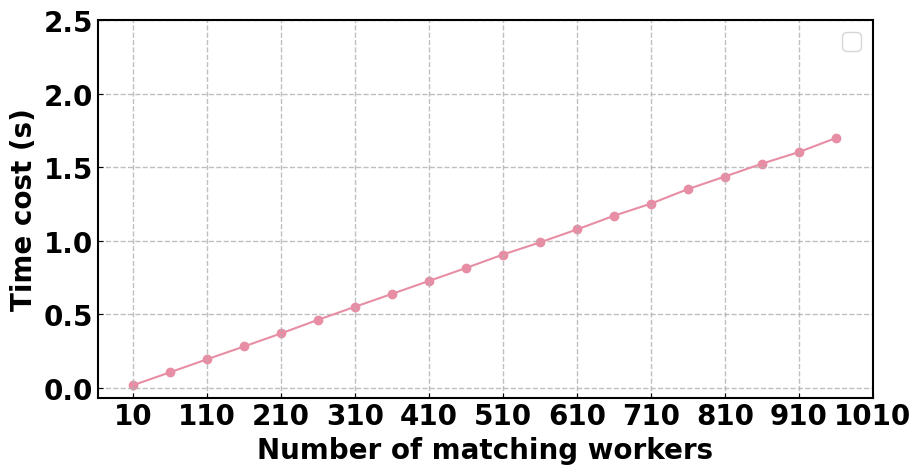

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from pylab import *
colorf=['#FDC1C5','#FFDA03','#85A3B2','#E78EA5']
colors =	['#FFA62B', '#75B3E7','#1B2431']
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(10,5),dpi=100)


TICK_SIZE = 20
LABEL_SIZE = 20
LEGEND_SIZE = 17
bwidth = 1.5

ax = plt.gca()
ax.spines['left'].set_linewidth(bwidth)
ax.spines['right'].set_linewidth(bwidth)
ax.spines['top'].set_linewidth(bwidth)
ax.spines['bottom'].set_linewidth(bwidth)

x=np.arange(10,1000,50)

families = 	[	'Times New Roman'
			]


plt.plot(x, allowlist_numberworker,
         c=colorf[3], label="")
plt.scatter(x,allowlist_numberworker,c=colorf[3])

plt.xticks(arange(10, 1050, 100), fontsize=TICK_SIZE, fontweight='bold')
plt.yticks(arange(0, 3, 0.5), fontsize=TICK_SIZE, fontweight='bold')

plt.grid(linestyle='--', linewidth=1, alpha=0.8)

plt.legend(loc='upper right', ncol=1, fontsize=LEGEND_SIZE)



plt.ylabel('Time cost (s)',fontsize=LABEL_SIZE,
			fontproperties=families[0], fontweight='bold')
plt.xlabel('Number of matching workers', fontsize=LABEL_SIZE,
			fontproperties=families[0], fontweight='bold')


plt.show()
